In [1]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
from nltk.corpus import stopwords

In [4]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [5]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [6]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='Russia.csv.bz2'

In [7]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/army/,NaN,Россия,Начался осенний призыв '99,В минувший четверг президент РФ Борис Ельцин п...,Россия,минувший рф борис ельцин подписать указ призыв...
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/bezhentsy/,NaN,Россия,Число беженцев в Ингушетии достигло 90 тысяч,"Мирные жители продолжают покидать Чечню, переб...",Россия,мирный житель продолжать покидать чечня переби...
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/chechnya_vlast/,NaN,Россия,Путин нашел в Москве новое правительство Чечни,В пятницу председатель российского правительст...,Россия,председатель российский правительство владимир...
3,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/chechnya_war/,NaN,Россия,Российская бронетанковая колонна вошла в Чечню,Несколько тысяч российских военных и около тыс...,Россия,тысяча российский военный около тысяча единица...
4,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/hotline/,NaN,Россия,Правозащитники помогают жертвам московского бе...,Московская хельсинкская группа с 1 октября отк...,Россия,московский хельсинкский 1 открывать горячий ли...


In [8]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [9]:
data['new_text']=data.text_lema.apply(pre_proc)

In [10]:
data.drop(data[data.text=='text'].index,inplace=True)

In [11]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/army/,NaN,Россия,Начался осенний призыв '99,В минувший четверг президент РФ Борис Ельцин п...,Россия,минувший рф борис ельцин подписать указ призыв...,"[минувший, рф, борис, ельцин, подписать, указ,..."
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/bezhentsy/,NaN,Россия,Число беженцев в Ингушетии достигло 90 тысяч,"Мирные жители продолжают покидать Чечню, переб...",Россия,мирный житель продолжать покидать чечня переби...,"[мирный, житель, продолжать, покидать, чечня, ..."
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/chechnya_vlast/,NaN,Россия,Путин нашел в Москве новое правительство Чечни,В пятницу председатель российского правительст...,Россия,председатель российский правительство владимир...,"[председатель, российский, правительство, влад..."
3,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/chechnya_war/,NaN,Россия,Российская бронетанковая колонна вошла в Чечню,Несколько тысяч российских военных и около тыс...,Россия,тысяча российский военный около тысяча единица...,"[тысяча, российский, военный, около, тысяча, е..."
4,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/hotline/,NaN,Россия,Правозащитники помогают жертвам московского бе...,Московская хельсинкская группа с 1 октября отк...,Россия,московский хельсинкский 1 открывать горячий ли...,"[московский, хельсинкский, 1, открывать, горяч..."


### Модель

In [12]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 20.7 s, sys: 35.5 ms, total: 20.7 s
Wall time: 20.7 s


In [13]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 16.4 s, sys: 428 ms, total: 16.8 s
Wall time: 16.8 s


In [14]:
num_topic=17

In [15]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=num_topic, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.480153517566544
Coherence Score: 0.6012056201065926
CPU times: user 1h 25min 44s, sys: 6.7 s, total: 1h 25min 51s
Wall time: 1h 11min 27s


### Топ-топики в текстах

In [16]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 26min 43s, sys: 3.01 s, total: 26min 46s
Wall time: 26min 59s


In [17]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.6262,"военный, служба","[минувший, рф, борис, ельцин, подписать, указ,..."
1,1,0.0,0.4652,"чечня, террористический","[мирный, житель, продолжать, покидать, чечня, ..."
2,2,8.0,0.4339,"россия, путин, глава, владимир, вопрос, подчер...","[председатель, российский, правительство, влад..."
3,3,0.0,0.4021,"чечня, глава","[тысяча, российский, военный, около, тысяча, е..."
4,4,12.0,0.2122,"россия, право, совет","[московский, хельсинкский, 1, открывать, горяч..."
5,5,14.0,0.1968,"рубль, миллион, средство","[правление, рао, еэс, россия, принять, решение..."
6,6,8.0,0.2801,"государство, вопрос, подчеркнуть","[рамка, проводить, государственный, департамен..."
7,7,16.0,0.5091,"выбор, кандидат, выборы, избирательный, пост","[владислав, ардзинб, избранный, самопровозглаш..."
8,8,5.0,0.3523,уголовный,"[бийск, алтайский, край, убитый, депутат, горо..."
9,9,0.0,0.3297,"республика, чечня, террорист","[кпп, место, временной, размещение, беженец, ч..."


### Статистика по топикам

In [18]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 91.9 ms, sys: 3.98 ms, total: 95.9 ms
Wall time: 647 ms


### График по времени

In [19]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/Russia_update.csv.bz2',compression='bz2', index=False)

CPU times: user 6min 29s, sys: 1.31 s, total: 6min 30s
Wall time: 6min 32s


In [20]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

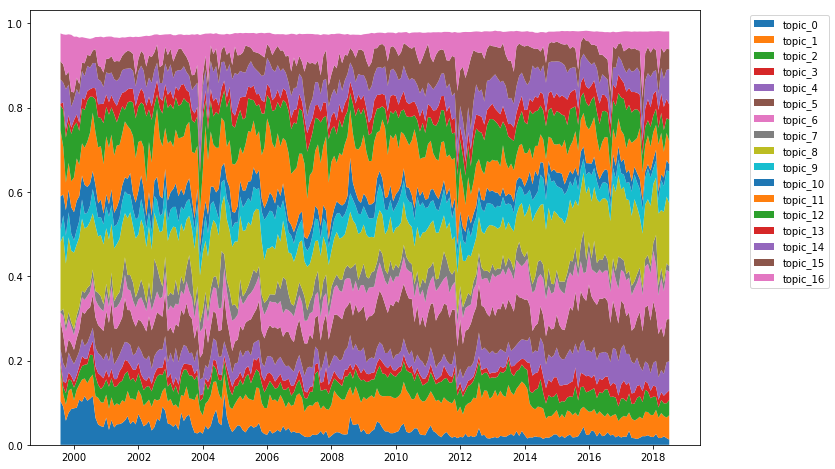

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [22]:
ldamodel1.print_topics()

[(0,
  '0.044*"тасс" + 0.031*"республика" + 0.020*"кадыров" + 0.020*"чечня" + 0.011*"террористический" + 0.009*"террорист" + 0.009*"теракт" + 0.009*"видеозапись" + 0.009*"глава" + 0.008*"рамзан"'),
 (1,
  '0.013*"уголовный" + 0.011*"статья" + 0.009*"прокуратура" + 0.008*"признать" + 0.008*"решение" + 0.008*"свобода" + 0.008*"обвинение" + 0.007*"бывший" + 0.007*"следствие" + 0.007*"следственный"'),
 (2,
  '0.030*"автомобиль" + 0.022*"водитель" + 0.022*"машина" + 0.019*"дорога" + 0.014*"движение" + 0.013*"дтп" + 0.012*"произойти" + 0.010*"авария" + 0.010*"автобус" + 0.010*"дорожный"'),
 (3,
  '0.043*"крым" + 0.041*"украина" + 0.022*"2017" + 0.021*"россия" + 0.021*"украинский" + 0.017*"севастополь" + 0.014*"киев" + 0.012*"2014" + 0.012*"республика" + 0.011*"российский"'),
 (4,
  '0.024*"российский" + 0.023*"россия" + 0.021*"сша" + 0.011*"сирия" + 0.010*"американский" + 0.009*"международный" + 0.009*"москва" + 0.007*"трамп" + 0.006*"мид" + 0.006*"мир"'),
 (5,
  '0.020*"ребёнок" + 0.019*"му

### Топ слова.

In [23]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [24]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [25]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

россия - 121720 times.
москва - 71101 times.
российский - 50049 times.
глава - 47746 times.
новость - 47736 times.
область - 45013 times.
рф - 44459 times.
интерфакс - 39730 times.
тысяча - 39083 times.
владимир - 37435 times.
данные - 36964 times.
путин - 36041 times.
место - 35452 times.
произойти - 34582 times.
рубль - 34445 times.
московский - 34186 times.
агентство - 31804 times.
депутат - 31318 times.
решение - 30132 times.
сотрудник - 29939 times.
около - 29797 times.
партия - 28642 times.
день - 28429 times.
район - 27645 times.
принять - 27365 times.
информация - 27040 times.
власть - 26920 times.
управление - 26377 times.
дом - 26173 times.
госдума - 25526 times.
орган - 25138 times.
уголовный - 25038 times.
задержать - 24947 times.
сайт - 24595 times.
правительство - 23790 times.
сергей - 23608 times.
ссылка - 23351 times.
вопрос - 23313 times.
связь - 21506 times.
регион - 21459 times.
федеральный - 21382 times.
выбор - 21178 times.
миллион - 21063 times.
закон - 20995 time